## Pre-processing

To pre-process the data, we'll tokenize the lines into words and remove punctuation.

In [0]:
import nltk
import numpy as np

# Load the data
shakespeare = [w.lower() for w in (open('shakespeare.txt', 'r').read()).split('\n')]
nltk.download('punkt')

grammar = [",", ";", ".", ":", "?", "(", ")", "!"]
word_list = []

for i in range(len(shakespeare)):
  if len(shakespeare[i]) > len(shakespeare[0]) + 2: # don't read the number lines
    line = [w for w in nltk.word_tokenize(shakespeare[i]) if w not in grammar]
    word_list.extend(line)

word_list = list(set(word_list))
num_words = len(word_list)

# Create dictionaries of the words to give them index values for easier training
word_int = {word:i for i, word in enumerate(word_list)}
int_word = {i:word for i, word in enumerate(word_list)}

# Create training data
train_X = []

for i in range(len(shakespeare)):
  if len(shakespeare[i]) > len(shakespeare[0]) + 2: # don't read the number lines
      line = [int(word_int[w]) for w in nltk.word_tokenize(shakespeare[i]) if w not in grammar]
      train_X.append(line)

In [0]:
# Read in syllable dictionary
dictf = open('Syllable_dictionary.txt', 'r').read().split('\n')
syll_dict = {}
end_dict = {}

for line in dictf:
  arr = line.split(' ')
  if len(arr) == 2:
    syll_dict[arr[0]] = int(arr[1])
  else:
    for i in range(1, len(arr)):
      if len(arr[i]) > 1:
        end_dict[arr[0]] = int(arr[i][1])
      else:
        syll_dict[arr[0]] = int(arr[i])


## Unsupervised Learning

In [0]:
def normalize(val):
    '''
    Normalize an array.
    
    Arguments:
        val:        Given array to normalize.
    '''
    val = np.copy(val)
    val /= val.sum()
    return np.nan_to_num(val)

In [0]:
import random
import numpy as np

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0.
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.

        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.

            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.

        Parameters:
            L:          Number of states.

            D:          Number of observations.

            A:          The transition matrix.

            O:          The observation matrix.

            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            alphas:     Vector of alphas.

                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.

                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''
        
        M = len(x)      # Length of sequence.
        alphas = np.array([np.array([0. for _ in range(self.L)]) for _ in range(M + 1)])
        alphas[1, :] = np.max(self.A_start * np.array(self.O)[np.newaxis, :, x[0]].T, 1)

        # Forward algorithm
        for i in range(2, M + 1):
          alphas[i, :] = alphas[i - 1].dot(np.array(self.A)) * np.array(self.O)[:, x[i - 1]]

        if normalize:
          alphas /= alphas.sum(axis=1, keepdims=True)
          alphas = np.nan_to_num(alphas) # in case we divide by 0

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            betas:      Vector of betas.

                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.

                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''
        M = len(x)      # Length of sequence.
        betas = np.array([np.array([0. for _ in range(self.L)]) for _ in range(M + 1)])
        betas[M] = np.ones((np.array(self.A).shape[0]))
 
        # Backwards algorithm
        for i in range(M - 1, -1, -1):
            for j in range(self.L):
                betas[i, j] = (betas[i + 1] * np.array(self.O)[:, x[i]]).dot(np.array(self.A)[j, :])
        
        if normalize:
            betas /= betas.sum(axis=1, keepdims=True)
            betas = np.nan_to_num(betas) # in case we divide by 0

        return betas


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.

            N_iters:    The number of iterations to train on.
        '''
        self.A = np.array(self.A)
        self.O = np.array(self.O)

        for n in range(N_iters):
          # Initialize
          A_num = np.zeros(np.shape(self.A))
          O_num = np.zeros(np.shape(self.O))
          A_denom = np.zeros(self.L)
          O_denom = np.zeros(self.L)
              
          for x in X:
              M = len(x)
              
              # E step
              alphas = self.forward(x, True) # normalize
              betas = self.backward(x, True) # normalize

              # M step: go through each value
              # Calculate gamma for the denominator of A and the numerator/denominator of O
              gamma = np.zeros((M+1, self.L))
              for t in range (1, M + 1):
                  gamma[t, :] = alphas[t, :].T * betas[t, :]
              # Normalize
              gamma /= gamma.sum(axis=1, keepdims=True)
              gamma = np.nan_to_num(gamma) # in case we divide by 0

              # Calculate the numerator for A
              xi = np.zeros((M, self.L, self.L))
              for t in range(1, M):
                  for i in range(self.L):
                      xi[t,i,:] = alphas[t, i] * self.A[i, :] * self.O[:, x[t]].T * betas[t + 1, :].T

              # Normalize
              for xi_t in xi[1:]:
                  if np.sum(xi_t) > 0:
                      xi_t /= np.sum(xi_t)

              # Update the numerators and denominators
              A_num += np.sum(xi, axis=0)
              A_denom += np.sum(gamma[1:M], axis=0)
              for t in range(1, M + 1):
                  O_denom += gamma[t]
                  for i in range(self.L):
                      O_num[i][x[t-1]] += gamma[t][i]
          
          self.A = np.copy(np.nan_to_num(A_num / A_denom[:, np.newaxis]))
          self.O = np.copy(np.nan_to_num(O_num / O_denom[:, np.newaxis]))
        

    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 

        Arguments:
            M:          Length of the emission to generate.

        Returns:
            emission:   The randomly generated emission as a list.

            states:     The randomly generated states as a list.
        '''
        # Initialize and pick a random state to start
        states = [np.random.randint(self.L)]
        emission = [np.random.choice(range(self.D), p = normalize(self.O[states[0]]))]
        
        for i in range(M - 1):
            # Pick the next state depending on the probability
            choice = np.random.choice(range(self.L), p = normalize(self.A_start)) if i == 0 else np.random.choice(range(self.L), p = normalize(self.A[states[i]]))
            states.append(choice)
            emission.append(np.random.choice(range(self.D), p = normalize(self.O[states[i + 1]])))

        return emission, states

    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob


## Poetry Generation, Part 1: Hidden Markov Models

In [0]:
def unsupervised_HMM(X, n_states, N_iters):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.

    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.

        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    
    # Compute L and D.
    L = n_states
    D = max(observations) + 1

    # Randomly initialize and normalize matrix A.
    random.seed(2020)
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    random.seed(155)
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

In [0]:
def sequence_generator(hmm, k, M, syllable_dict=syll_dict, int_dict=int_word):
    '''
    Generates k emissions of length M using the HMM for a given n
    and prints the results.

    Arguments:
        hmm:        HMM to use.
        K:          Number of sequences to generate.
        M:          Length of emission to generate.
        syllable_dict:  Syllable dictionary to use.
        int_dict:       Integer to word dictionary to use.
    '''
    # Generate k input sequences.
    for i in range(k):
      syllables = 0
      while syllables != 10:
        # Generate a single input sequence of length m.
        emission, states = hmm.generate_emission(M)
        syllables = 0
        generated = ""
        for i in emission:
          if syllables != 10:
            if str(int_dict[i]) not in syllable_dict:
              syllables = 100
              break
            syllables += syllable_dict[str(int_dict[i])]
            generated += u" " + str(int_dict[i])
      
      # Print the results.
      print(generated.strip().capitalize())

    print('')
    print('')

In [0]:
# Unsupervised HMM learninig
n_states = 10
n_iters = 100
unsup_HMM = unsupervised_HMM(train_X, n_states, n_iters)

In [0]:
# Generate sonnet
sequence_generator(unsup_HMM, 14, 10)

To with beauty that more i store so heir
When wilfulness goddess and love and threw
Me all alone living shore that present
Argument thy thou which once never there
More best bond of less thy muse with the have
Ill i rearward spend am no breath and taught
Before hide brav'ry art not bright nothing
Trenches but death when whether how see you
Or thee form seem thou were noon o preserve
As altered which breath die image for catch
Should wish i o'erlook i afterwards have
So come of made right blushing both a thou
Two enemies and prove form doth and time
Mind fast but thy heart and shape what self die




## Poetry Generation, Part 2: Recurrent Neural Networks

In [0]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Lambda
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import plot_model, to_categorical

import nltk
import sys
import numpy as np
import random
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# Helper method in determining whether line is a poem number
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
    
# Load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

shakespeare = load_doc('shakespeare.txt')
# Remove all lines that are just line numbers
tokens = shakespeare.split('\n')
for i in range(len(tokens) - 1, -1, -1):
    if RepresentsInt(tokens[i]):
        tokens.pop(i)
# The entire file of sonnets, minus line numbers, as a string
raw_text = '\n'.join(tokens)

In [0]:
# Each sequence has 40 characters. 
training_length = 40

# Generate sequences of training_length + 1, where index 0 up to (not 
# including) index  training_length is the input, and index training_length
# is the output character
def gen_seqs(text, n):
    raw_seqs = list()
    for i in range(training_length, len(text), n):
        seq = text[i - training_length:i + 1]
        # Append every n'th sequence of training_length + 1
        raw_seqs.append(seq)
    return raw_seqs

# Take every 4'th character
raw_seqs = gen_seqs(raw_text, 4)

# Save tokens to file, one dialog per line
def save_doc(lines, filename):
    # We use a special character that does not appear in the raw text
    data = '*'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()    
# save sequences to file
out_filename = 'char_sequences.txt'
save_doc(raw_seqs, out_filename)

In [0]:
in_filename = 'char_sequences.txt'
raw_split = load_doc(in_filename)
# Split the training sequences and output characters using the special
# character
lines = raw_split.split('*')

# Create the mapping between integers and characters and vice versa.
chars = sorted(list(set(raw_text)))
mapping = dict((c, i) for i, c in enumerate(chars))
r_mapping = dict((i, c) for i, c in enumerate(chars))

# Process each sequence of characters
sequences = list()
for line in lines:
    # Integer encode the line
    encoded_seq = [mapping[char] for char in line]
    sequences.append(encoded_seq)

vocab_size = len(mapping)
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 61


In [0]:
sequences = np.array(sequences)
# Split overall sequences into training sequences and output character
X, y = sequences[:,:-1], sequences[:,-1]
# One-hot encode the inputs
sequences = [to_categorical(x, num_classes=vocab_size) for x in X]
X = np.array(sequences)
# One-hot encode the output characters
y = to_categorical(y, num_classes=vocab_size)
print(np.shape(X))

(23639, 40, 61)


In [0]:
# Build the model.
def build_model(temp):
    model = Sequential()

    # A single recurrent layer, so return sequences is
    # set to false
    model.add(LSTM(150, return_sequences=False, 
                   input_shape=(X.shape[1], X.shape[2])))
    
    # Lambda layer used to change the temperature parameter
    model.add(Lambda(lambda x: x / temp))

    # Fully connected output layer with softmax activation
    model.add(Dense(vocab_size, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
# Determine the best LSTM layer size to use
test_nodes = [135, 145, 165, 185, 195]
best_nodes = test_nodes[0]
min_loss = 10
for num_nodes in test_nodes:
    test_model = build_model(num_nodes, 1)
    callback = [EarlyStopping(monitor='loss', patience=8, 
                           restore_best_weights = True, mode='min')]
    hist = test_model.fit(X, y, batch_size=128, epochs=200, callbacks=callback, verbose=2)
    curr_loss = min(hist.history['loss'])
    if curr_loss < min_loss:
        min_loss = curr_loss
        best_nodes = num_nodes
print("Best number of nodes to use: " + str(best_nodes))

In [0]:
# Determine the best batch size to use
test_bs = [32, 40, 75, 100, 128]
best_bs = test_bs[0]
min_loss = 10
for bs in test_bs:
    test_model = build_model(best_nodes, 1)
    callback = [EarlyStopping(monitor='loss', patience=8, 
                           restore_best_weights = True, mode='min')]
    hist = test_model.fit(X, y, batch_size=bs, epochs=200, callbacks=callback, verbose=2)
    curr_loss = min(hist.history['loss'])
    if curr_loss < min_loss:
        min_loss = curr_loss
        best_bs = bs
print("Best batch size to use: " + str(best_bs))

In [0]:
# Build models using different temperatures
modelt1 = build_model(best_nodes, 0.25)
modelt2 = build_model(best_nodes, 0.75)
modelt3 = build_model(best_nodes, 1.5)
pathname1 = 'models/model_0_25.h5'
pathname2 = 'models/model_0_75.h5'
pathname3 = 'models/model_1_50.h5'

# Create callbacks
callback1 = [EarlyStopping(monitor='loss', patience=8, 
                           restore_best_weights = True, mode='min')]
callback2 = [EarlyStopping(monitor='loss', patience=8, 
                           restore_best_weights = True, mode='min')]
callback3 = [EarlyStopping(monitor='loss', patience=8, 
                           restore_best_weights = True, mode='min')]

In [0]:
modelt1.fit(X, y, batch_size=best_bs, epochs=200, callbacks=callback1, verbose=2)
modelt1.save(pathname1)

Epoch 1/150
 - 14s - loss: 2.9533 - acc: 0.2102
Epoch 2/150
 - 14s - loss: 2.3973 - acc: 0.3248
Epoch 3/150
 - 15s - loss: 2.2384 - acc: 0.3515
Epoch 4/150
 - 15s - loss: 2.1519 - acc: 0.3743
Epoch 5/150
 - 15s - loss: 2.0850 - acc: 0.3921
Epoch 6/150
 - 15s - loss: 2.0218 - acc: 0.4079
Epoch 7/150
 - 15s - loss: 1.9747 - acc: 0.4186
Epoch 8/150
 - 16s - loss: 1.9278 - acc: 0.4284
Epoch 9/150
 - 15s - loss: 1.8854 - acc: 0.4406
Epoch 10/150
 - 15s - loss: 1.8462 - acc: 0.4478
Epoch 11/150
 - 15s - loss: 1.8101 - acc: 0.4580
Epoch 12/150
 - 15s - loss: 1.7702 - acc: 0.4669
Epoch 13/150
 - 15s - loss: 1.7365 - acc: 0.4722
Epoch 14/150
 - 15s - loss: 1.6982 - acc: 0.4832
Epoch 15/150
 - 15s - loss: 1.6637 - acc: 0.4918
Epoch 16/150
 - 15s - loss: 1.6284 - acc: 0.5002
Epoch 17/150
 - 16s - loss: 1.5899 - acc: 0.5103
Epoch 18/150
 - 15s - loss: 1.5493 - acc: 0.5223
Epoch 19/150
 - 15s - loss: 1.5075 - acc: 0.5324
Epoch 20/150
 - 15s - loss: 1.4636 - acc: 0.5480
Epoch 21/150
 - 15s - loss: 1

In [0]:
modelt2.fit(X, y, batch_size=best_bs, epochs=200, callbacks=callback2, verbose=2)
modelt2.save(pathname2)

Epoch 1/150
 - 16s - loss: 3.1175 - acc: 0.1709
Epoch 2/150
 - 15s - loss: 2.6865 - acc: 0.2638
Epoch 3/150
 - 15s - loss: 2.3760 - acc: 0.3233
Epoch 4/150
 - 15s - loss: 2.2547 - acc: 0.3509
Epoch 5/150
 - 16s - loss: 2.1605 - acc: 0.3753
Epoch 6/150
 - 16s - loss: 2.0934 - acc: 0.3945
Epoch 7/150
 - 15s - loss: 2.0430 - acc: 0.4051
Epoch 8/150
 - 15s - loss: 1.9974 - acc: 0.4170
Epoch 9/150
 - 15s - loss: 1.9552 - acc: 0.4250
Epoch 10/150
 - 15s - loss: 1.9213 - acc: 0.4354
Epoch 11/150
 - 15s - loss: 1.8845 - acc: 0.4439
Epoch 12/150
 - 16s - loss: 1.8511 - acc: 0.4533
Epoch 13/150
 - 15s - loss: 1.8173 - acc: 0.4586
Epoch 14/150
 - 15s - loss: 1.7877 - acc: 0.4692
Epoch 15/150
 - 15s - loss: 1.7577 - acc: 0.4744
Epoch 16/150
 - 16s - loss: 1.7285 - acc: 0.4806
Epoch 17/150
 - 15s - loss: 1.6976 - acc: 0.4888
Epoch 18/150
 - 17s - loss: 1.6723 - acc: 0.4974
Epoch 19/150
 - 15s - loss: 1.6407 - acc: 0.5056
Epoch 20/150
 - 15s - loss: 1.6108 - acc: 0.5122
Epoch 21/150
 - 15s - loss: 1

In [0]:
modelt3.fit(X, y, batch_size=best_bs, epochs=250, callbacks=callback3, verbose=2)
modelt3.save(pathname3)

Epoch 1/250
 - 17s - loss: 3.1469 - acc: 0.1684
Epoch 2/250
 - 16s - loss: 2.9813 - acc: 0.1775
Epoch 3/250
 - 16s - loss: 2.7445 - acc: 0.2613
Epoch 4/250
 - 16s - loss: 2.5429 - acc: 0.2994
Epoch 5/250
 - 16s - loss: 2.4252 - acc: 0.3182
Epoch 6/250
 - 16s - loss: 2.3484 - acc: 0.3350
Epoch 7/250
 - 16s - loss: 2.2939 - acc: 0.3449
Epoch 8/250
 - 16s - loss: 2.2409 - acc: 0.3567
Epoch 9/250
 - 17s - loss: 2.1899 - acc: 0.3706
Epoch 10/250
 - 16s - loss: 2.1510 - acc: 0.3817
Epoch 11/250
 - 16s - loss: 2.1171 - acc: 0.3894
Epoch 12/250
 - 16s - loss: 2.0866 - acc: 0.3976
Epoch 13/250
 - 16s - loss: 2.0643 - acc: 0.4027
Epoch 14/250
 - 16s - loss: 2.0445 - acc: 0.4066
Epoch 15/250
 - 17s - loss: 2.0207 - acc: 0.4115
Epoch 16/250
 - 16s - loss: 1.9997 - acc: 0.4177
Epoch 17/250
 - 16s - loss: 1.9819 - acc: 0.4218
Epoch 18/250
 - 16s - loss: 1.9671 - acc: 0.4248
Epoch 19/250
 - 18s - loss: 1.9532 - acc: 0.4295
Epoch 20/250
 - 16s - loss: 1.9349 - acc: 0.4320
Epoch 21/250
 - 16s - loss: 1

In [0]:
from keras.models import load_model

modelt1 = load_model(pathname1)
modelt2 = load_model(pathname2)
modelt3 = load_model(pathname3)

In [0]:
def generate_poem(model, mapping, seq_length, seed_text):
    in_text = ''
    seq = seed_text
    newline = 0
    while newline < 14:
        # encode the characters as integers
        encoded = [mapping[char] for char in seq]
        # truncate sequences to a fixed length (if seed is greater than 40 
        # lines long)
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # one hot encode
        encoded = to_categorical(encoded[0], num_classes=vocab_size)
        encoded = encoded.reshape(1, encoded.shape[0], encoded.shape[1])
        # predict character
        pred = model.predict_classes(encoded, verbose=0)
        # reverse map integer to character and append to input
        next_char = r_mapping[pred[0]]
        if next_char != '\n':
            in_text += next_char
        else:
            # Make sure that two newlines in a row are not outputted
            if (next_char == '\n' and (len(in_text) > 0 and \ 
                                       in_text[len(in_text) - 1] != '\n')):
                in_text += next_char
                newline += 1
        seq = seq[1:] + next_char
    return in_text

seed = "shall i compare thee to a summer's day\n"
print('Using T = 0.25:')
print(generate_poem(modelt1, mapping, 40, seed))
print('Using T = 0.75:')
print(generate_poem(modelt2, mapping, 40, seed))
print('Using T = 1.5:')
print(generate_poem(modelt3, mapping, 40, seed))

Using T = 0.25:
That lle I menoned with succongin do:n:
Then haur gaccaan fol of fars sweet love,
As ofry them be, asccoun,
  And leve's plass ade hllatt timms' with erengne,
To sammentel futherent foret disin,
My save that bucoonerswith hoo thin my and,
  And herv'thess, thence an meatury gand.
Whaince that thy coold and thou art and here
Whe send the chace con on stcee lled,
  Oy love thoe parp thee facceat, of both,
  Whe haad that ther freme,
The bence forrongrancy and love hatr where
Whon the prien of deth thee I bove chnoue.
The cack my hat to secas dedw which thee some all,

Using T = 0.75:
To that mo I con the with my will no prasse
For the froce will west batty aw's ruse,
Tid if their stray their pastusing ow,
Saken in their st be wher
s pend at thred by sake me east foust of exert,
And merath healt thy seld revenous peest,
I fanst when thou dosp ond theis putt seee,
Wist the brit love that you grean periee,
Theriof thy sedf's conndes in thise can and,
Litht thy beart, and bee

## Additional Goals

### Incorporating Additional Texts

We can incorporate Spenser's work as well.

In [0]:
import nltk
import numpy as np

# Load the data
spenser = [w.lower() for w in (open('spenser.txt', 'r').read()).split('\n')]
nltk.download('punkt')
nltk.download('cmudict')

# Use the CMU’s Pronouncing Dictionary
from nltk.corpus import cmudict
d = cmudict.dict()

# Add on to our Shakespeare lists
grammar = [",", ";", ".", ":", "?", "(", ")", "!"]
full_word_list = word_list.copy()
full_syll_dict = syll_dict.copy()

for i in range(len(spenser)):
  if len(spenser[i]) > len(spenser[0]) + 10: # don't read the number lines
    seq = spenser[i].replace("-", " ")
    line = [w for w in nltk.word_tokenize(seq) if w not in grammar and w.isalpha()]
    if all(w in d for w in line):
      for w in line:
        if w not in full_syll_dict:
          syllables = [len(list(y for y in x if y[-1].isdigit())) for x in d[w]][0]
          full_syll_dict[w] = syllables
      full_word_list.extend(line)

full_word_list = list(set(full_word_list))
full_num_words = len(full_word_list)

# Create dictionaries of the words to give them index values for easier training
full_word_int = {word:i for i, word in enumerate(full_word_list)}
full_int_word = {i:word for i, word in enumerate(full_word_list)}

# Create training data
full_train_X = train_X.copy()

for i in range(len(spenser)):
  if len(spenser[i]) > len(spenser[0]) + 10: # don't read the number lines
    seq = spenser[i].replace("-", " ")
    line = [w for w in nltk.word_tokenize(seq) if w not in grammar and w.isalpha()]
    if all(w in full_word_list for w in line):
      train_line = [int(full_word_int[w]) for w in line]
      full_train_X.append(train_line)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [0]:
# Unsupervised HMM learninig
n_states = 10
n_iters = 100
full_HMM = unsupervised_HMM(full_train_X, n_states, n_iters)

In [0]:
sequence_generator(full_HMM, 14, 10, syllable_dict=full_syll_dict, int_dict=full_int_word)

Seeking strains let spirits ladies smiling
Fixed so away receive quill dust that love
Thou locks filching spirits chace wilfully
Believed sharp'st pitch melts catch hues scythe ensconce
Couldst then from that she admire workmanship
Trifles seek fame joyous attire dust
Forms sacred wear they fly my days to as
Sharp'st onwards dangerous titles pleasure
Well-tuned heavens she cause be spirits
Cordials servant had and pay resort rough
Mercy and ye prison it heaven sought
Painful raging overcast hunts pupil
Inferior love true with and created
And that thing lark called resort sharp'st bay called




### Incorporating Rhyme

We first create a rhyming dictionary from Shakespeare's sonnets and then generate emissions backwards.

In [0]:
# Initiliaze
rhyme_dict = {}

# Keep track of how many lines we've gone through
count, l = 0, 1
a = []
b = []
last = False
grammar.append('\'')

# Unfortunately poem 99 and 126 do not follow the usual pattern so we need
# to handle these poems separately
skip = False

# Go through each abab line scheme and add to our rhyming dictionary
for i in range(len(shakespeare)):
  # Why did Shakespeare create two poems that are irregular to his usual
  # style? The world will never know.
  if shakespeare[i].strip() == "99" or shakespeare[i].strip() == "126":
    skip = True
  if shakespeare[i].strip() == "100" or shakespeare[i].strip() == "127":
    skip = False
  if not skip:
    if len(shakespeare[i]) > len(shakespeare[0]) + 2: # don't read the number lines
      line = [w for w in nltk.word_tokenize(shakespeare[i]) if w not in grammar]
      
      # If we are at the end of the poem
      if (l + 1) % 14 == 0 and l != 0:
        last = True
        word = line[-1] if line[-1] not in grammar else line[-2]
        a.append(word)
      elif last:
        word = line[-1] if line[-1] not in grammar else line[-2]
        a.append(word)
        last = False
      else:
        if l % 2 == 0:
          word = line[-1] if line[-1] not in grammar else line[-2]
          a.append(word)
        else:
          word = line[-1] if line[-1] not in grammar else line[-2]
          b.append(word)
        
      if len(a) == 2:
        rhyme_dict[count] = a
        count += 1
        a = []
      if len(b) == 2:
        rhyme_dict[count] = b
        count += 1
        b = []
      l += 1

In [0]:
def generate_backwards_emission(hmm, start, M):
    '''
    Generates a backwards emission of length M, assuming that the starting
    state is given. 

    Arguments:
        hmm:        Given HMM.
        start:      Rhyme end.
        M:          Length of the emission to generate.

    Returns:
        emission:   The randomly generated emission as a list.

        states:     The randomly generated states as a list.
    '''
    # Initialize
    emission = [start]
    states = [np.random.choice(range(hmm.L), p = normalize(hmm.O[:,start]))]
    
    for i in range(M - 1):
        # Pick the next state depending on the probability
        choice = np.random.choice(range(hmm.L), p = normalize(hmm.A[states[i], :]))
        states.append(choice)
        emission.append(np.random.choice(range(hmm.D), p = normalize(hmm.O[states[i + 1], :])))

    return emission, states

In [0]:
def rhyme_sequence_generator(hmm, k, M, syllable_dict=syll_dict, int_dict=int_word, word_dict=word_int):
    '''
    Generates k emissions of length M using the HMM for a given n
    and prints the results.

    Arguments:
        hmm:        HMM to use.
        K:          Number of sequences to generate.
        M:          Length of emission to generate.
        syllable_dict:  Syllable dictionary to use.
        int_dict:       Integer to word dictionary to use.
        word_dict:      Word to integer dictionary to use.
    '''
    # Generate k input sequences.
    a_rhyme = []
    b_rhyme = []
    last = False
    for i in range(int(k/2)):
      choice = np.copy(rhyme_dict[np.random.choice(len(rhyme_dict))])
      random.shuffle(choice)
      a_rhyme.extend(choice)
      choice = np.copy(rhyme_dict[np.random.choice(len(rhyme_dict))])
      random.shuffle(choice)
      b_rhyme.extend(choice)

    for i in range(k):
      syllables = 0
      if i == k - 2:
        word = a_rhyme.pop(0)
        last = True
      elif last:
        word = a_rhyme.pop(0)
        last = False
      else:
        if i % 2 == 0:
          word = a_rhyme.pop(0)
        else:
          word = b_rhyme.pop(0)

      while syllables != 10:
        # Generate a single input sequence of length m.
        emission, states = generate_backwards_emission(hmm, int(word_dict[word]), M)
        syllables = 0
        generated = ""
        for i in emission:
          if syllables != 10:
            if str(int_dict[i]) not in syllable_dict:
              syllables = 100
              break
            syllables += syllable_dict[str(int_dict[i])]
            generated = str(int_dict[i]) + " " + generated

      # Print the results.
      print(generated.capitalize())

    print('')
    print('')

In [0]:
# Generate sonnet with Shakespeare's work
rhyme_sequence_generator(unsup_HMM, 14, 10)

Dumb from manners by that how worse couldst verse 
Part his where scorned it make each can is play 
Hair true year bareness compare some rehearse 
Great love is after face worthier away 
Their live such thou that how doth thou friend sight 
Heart my eyes plagues pent blood thou their high black 
Then says scorn name my with oppressed of night 
Power world the are name things one is hue lack 
Just to receives love the when is desire 
Thy wretch why poor repair see men to left 
Day the left to turned on of tend conspire 
Beauty i wilfully sparkling bereft 
Lovely three sovereign my thou back a prime 
Must is and level thou it i holds time 




### Generating other Poetic Forms

We can generate other poetic forms, such as haikus.

In [0]:
def haiku_generator(hmm, k, M, syllable_dict=syll_dict, int_dict=int_word):
    '''
    Generates k emissions of length M using the HMM for a given n
    and prints the results.

    Arguments:
        hmm:        HMM to use.
        K:          Number of sequences to generate.
        M:          Length of emission to generate.
        syllable_dict:  Syllable dictionary to use.
        int_dict:       Integer to word dictionary to use.
    '''
    # Generate k input sequences.
    odd = True
    limit = 0

    for i in range(k):
      syllables = 0
      if odd:
        odd = False
        limit = 5
      else:
        odd = True
        limit = 7
      while syllables != limit:
        # Generate a single input sequence of length m.
        emission, states = hmm.generate_emission(M)
        syllables = 0
        generated = ""
        for i in emission:
          if syllables != limit:
            if str(int_dict[i]) not in syllable_dict:
              syllables = 100
              break
            syllables += syllable_dict[str(int_dict[i])]
            generated += u" " + str(int_dict[i])
      
      # Print the results.
      print(generated.strip().capitalize())

    print('')
    print('')

In [0]:
# Generate haiku
haiku_generator(unsup_HMM, 3, 7)

Garments it on thee
Favour weeds more better say
Belied majesty




## Visualization (using the TA's visualization from HW 6)

In [0]:
import os
import numpy as np
from IPython.display import HTML

from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    parse_observations,
    sample_sentence,
    visualize_sparsities,
    animate_emission
)

We can visualize the dataset in a wordcloud.

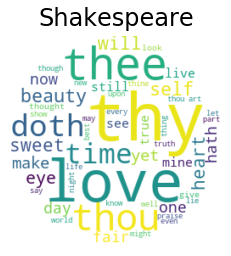

In [0]:
text = open('shakespeare.txt').read()
wordcloud = text_to_wordcloud(text, title='Shakespeare')

We can also visualize the sparsities of our A and O matrices, our state transition and observation/emission matrices.

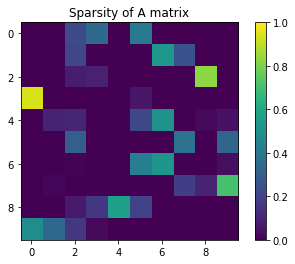

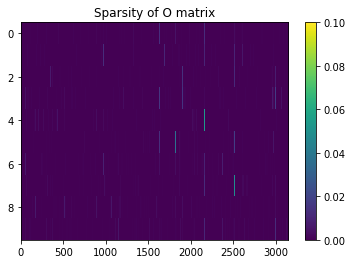

In [0]:
visualize_sparsities(unsup_HMM, O_max_cols=unsup_HMM.D)

We can also visualize each state as a wordcloud.

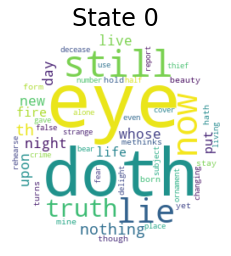

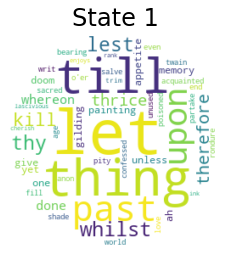

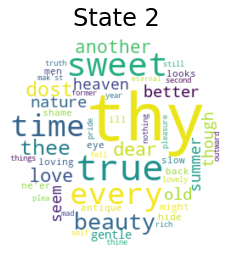

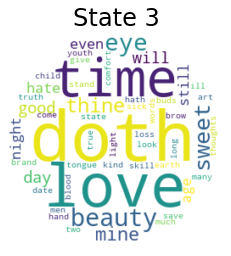

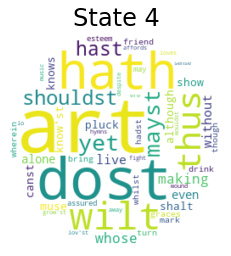

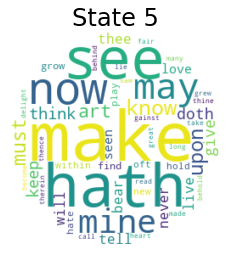

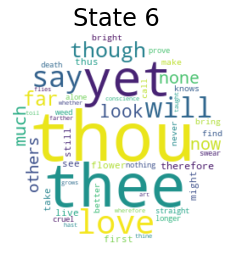

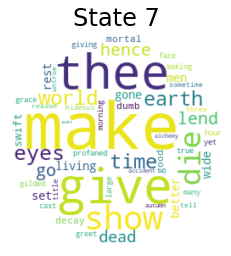

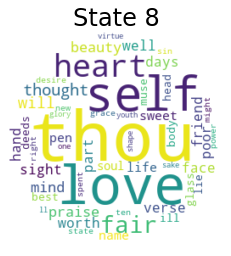

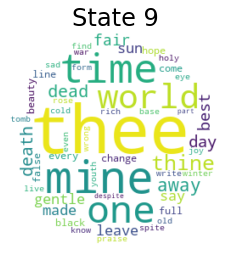

In [0]:
wordclouds = states_to_wordclouds(unsup_HMM, word_int)

Animating a line generation shows us how our HMM generates one line from the various states.


Animating...


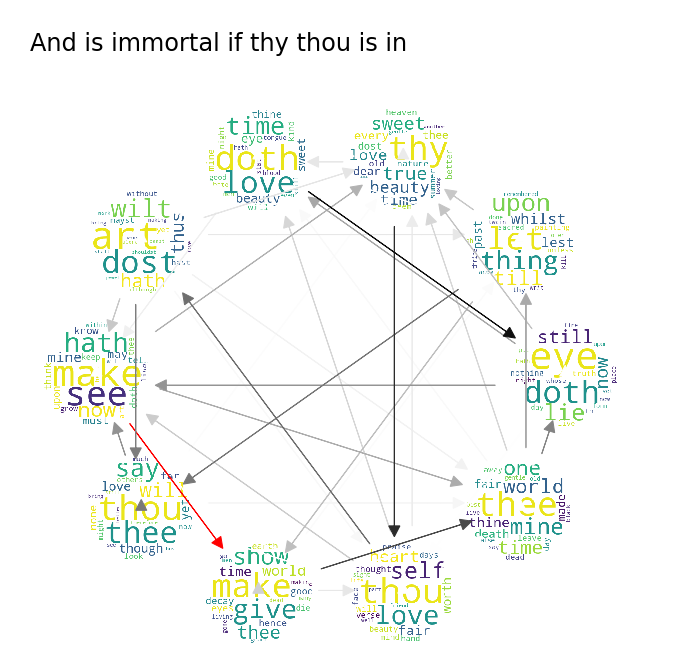

In [0]:
anim = animate_emission(unsup_HMM, word_int, M=8)
HTML(anim.to_html5_video())

In [0]:
# 
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
hmm_sentiment = {"neutral": 0, "positive": 0, "negative": 0}
import pandas as pd
# Read in three generated sonnets generated by a HMM. sonnet1 is generated
# using Shakesperean and Spenserian texts. sonnet2 and sonnet3 are generated
# with Shakesperean sonnet rhyme scheme.
hmm_sonnet1 = open('hmm1.txt','r').read().split(' \n')
hmm_sonnet2 = open('hmm2.txt','r').read().split(' \n')
hmm_sonnet3 = open('hmm3.txt','r').read().split(' \n')
hmm_sonnets = [hmm_sonnet1, hmm_sonnet2, hmm_sonnet3]

# Classify each line as neutral, positive, or negative
for sonnet in hmm_sonnets:
  for line in sonnet:
      sentiment_score = sid.polarity_scores(line)
      if sentiment_score["compound"] == 0.0:
          hmm_sentiment["neutral"] += 1
      elif sentiment_score["compound"] > 0.0:
          hmm_sentiment["positive"] += 1
      else:
          hmm_sentiment["negative"] += 1
print(hmm_sentiment)

rnn_sentiment = {"neutral": 0, "positive": 0, "negative": 0}
# Read in three generated sonnets generated by a HMM. sonnet1, sonnet2, and 
# sonnet3 are generated using T = 0.25, 0.75, 1.5 respectively.
rnn_sonnet1 = open('rnn1.txt','r').read().split('\n')R
rnn_sonnet2 = open('rnn2.txt','r').read().split('\n')
rnn_sonnet3 = open('rnn3.txt','r').read().split('\n')
rnn_sonnets = [rnn_sonnet1, rnn_sonnet2, rnn_sonnet3]
# Classify each line as neutral, positive, or negative
for sonnet in rnn_sonnets:
  for line in sonnet:
      sentiment_score = sid.polarity_scores(line)
      if sentiment_score["compound"] == 0.0:
          rnn_sentiment["neutral"] += 1
      elif sentiment_score["compound"] > 0.0:
          rnn_sentiment["positive"] += 1
      else:
          rnn_sentiment["negative"] += 1
print(rnn_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
{'neutral': 4, 'positive': 18, 'negative': 6}
{'neutral': 29, 'positive': 9, 'negative': 4}


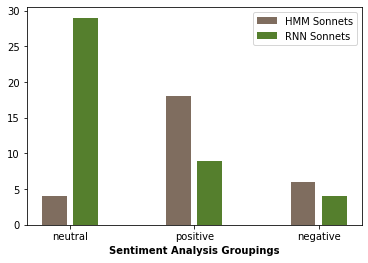

In [0]:
# Plot bar graphs comparing perceived sentiments in poems generated by a HMM
# and by a RNN
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
ax = plt.subplot(111)

y1 = hmm_sentiment.values()
y2 = rnn_sentiment.values()
barWidth = 0.25
r1 = np.arange(len(y1))
r2 = [x + barWidth for x in r1]
hmm = ax.bar(r1, y1, width=0.2, color='#7f6d5f', align='center')
rnn = ax.bar(r2, y2, width=0.2, color='#557f2d', align='center')
ax.xaxis_date()

plt.xlabel('Sentiment Analysis Groupings', fontweight='bold')
plt.xticks([r + 0.5 * barWidth for r in range(len(y1))], \
           ['neutral', 'positive', 'negative'])

plt.legend([hmm, rnn], ['HMM Sonnets', 'RNN Sonnets'])
plt.show()